### Validation for the first time. Bad results

<a href="https://pollytikhonova.github.io/coursework/validation"><img src="https://pollytikhonova.github.io/coursework/GitHub-Mark-32px.png" alt="В репозиторий" title="В репозиторий" style="max-width:100%;  display: inline-block; margin-right: 10px;"></a> <a href="Train,Predict&Validate. First time.ipynb" download target="_blank">Скачать этот ipunb-файл можно здесь</a>

In [1]:
import sys
sys.path.insert(0, '../basic codes')

from class_magnesium_not_drop_na import *
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
class Magnesium_validation(Magnesium):    
    def __init__(self, validation_file, *args, **kwargs):
        super(Magnesium_validation, self).__init__(*args, **kwargs)
        self.validation_data = pd.read_table(validation_file).fillna(method = 'backfill', axis = 0)
        if np.sum(self.validation_data.isnull().any(axis=1)) > 0:
            self.validation_data.fillna(method = 'pad', axis = 0, inplace = True)
        self.validation_data = self.validation_data[~(self.validation_data['chainlen']>1000)]
        self.x_test = np.matrix(self.validation_data[list(self.validation_data.columns)[2:-1]])
        self.y_test = np.array(self.validation_data[list(self.validation_data.columns)[-1]])
        self.data = self.data[~self.data['pdb_chain'].isin(self.validation_data['pdb_chain'])]
        self.data_numpy = np.matrix(self.data)
        self.x = self.data_numpy[:, 1:-1]
        self.y = np.array(self.data_numpy[:,-1].flatten().tolist()[0]) 
        
    def train(self, n_splits):
        self.trained_model = self.model
        x = self.x
        y = self.y
        sss = StratifiedShuffleSplit(n_splits = n_splits, test_size = 0.3, random_state = 0)
        rus = RandomUnderSampler(ratio = 'auto', random_state=42)
        
        splitted = sss.split(x, y) 
        iterator = tqdm_notebook(splitted, desc = "Splits", leave = True) if tqdm else splitted            
        for train_index, test_index in iterator:               
            x_train, y_train = rus.fit_sample(x[train_index], y[train_index])
            self.trained_model.fit(x_train, y_train)
            
    def compute(self, n_splits = 3):
        self.train(n_splits)
        data = self.predict(x = self.x_test, y = self.y_test)
        self.show_plots(data['plots'])                
        return data        

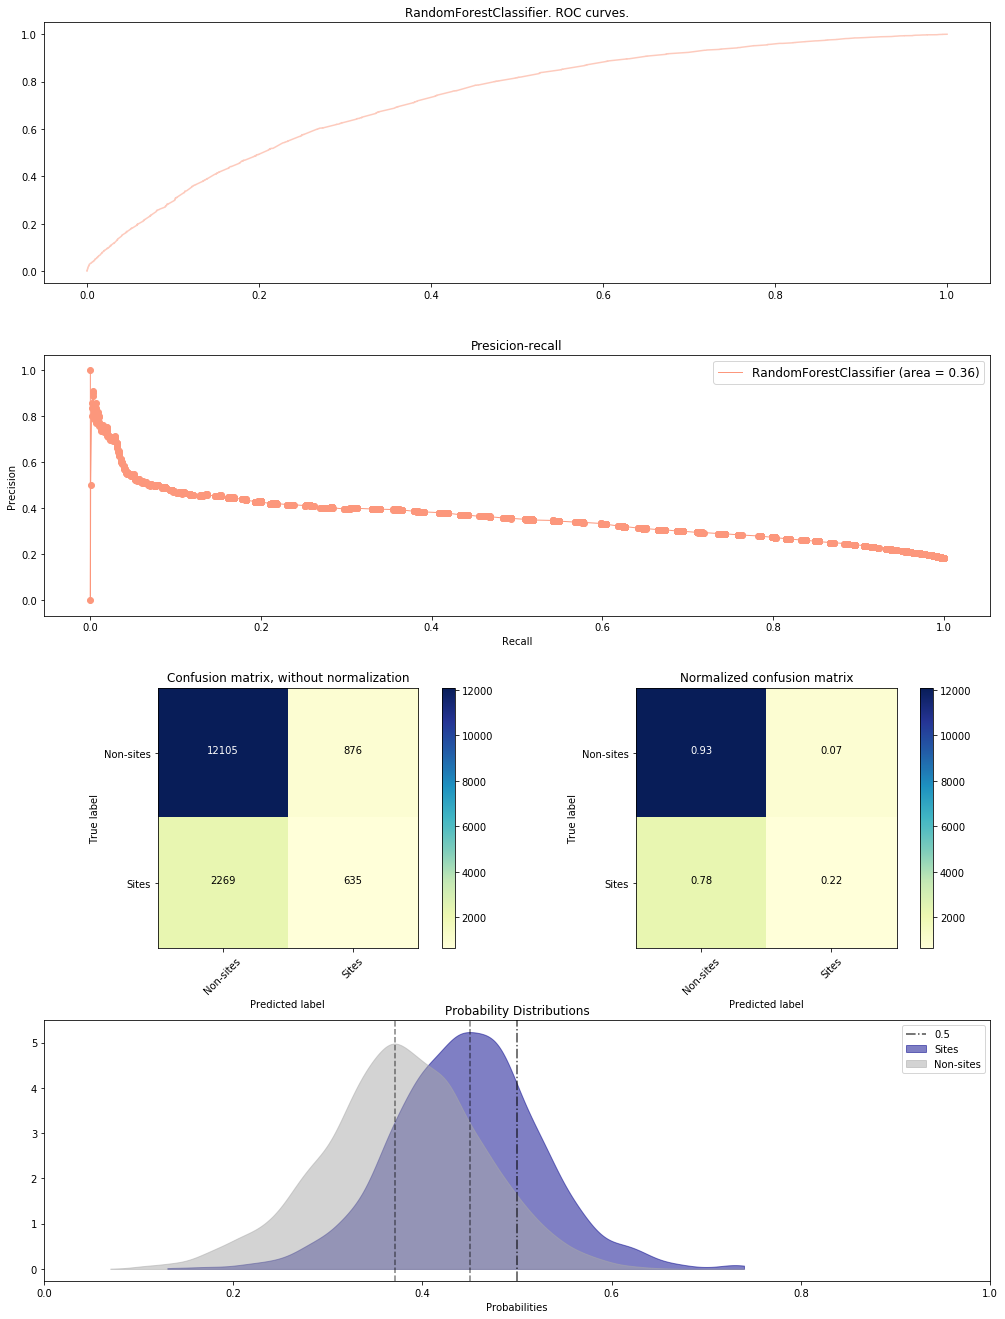

In [3]:
fold = 'https://tikhonovapolly.files.wordpress.com/2017/09/'
m = Magnesium_validation('data/set_val_A_7.csv', file_ = "set_minresol_a_7_1000.doc", fold = fold,
                        model = RandomForestClassifier(n_estimators=200, n_jobs=-1, criterion='gini',
                                                      max_depth = 39, min_samples_leaf = 1))
pdf_pages = PdfPages('outputs/Predictions_A7_minresol.pdf')
data = m.compute(n_splits = 7)
pdf_pages.savefig()
pdf_pages.close()

In [10]:
maxes = [i for i in data['plots']['prob_density'] if 'plt.axvline' in i]
tresh1 = float(maxes[0].split('(')[1].split(',')[0])
tresh2 = 0.4
tresh3 = float(maxes[2].split('(')[1].split(',')[0])

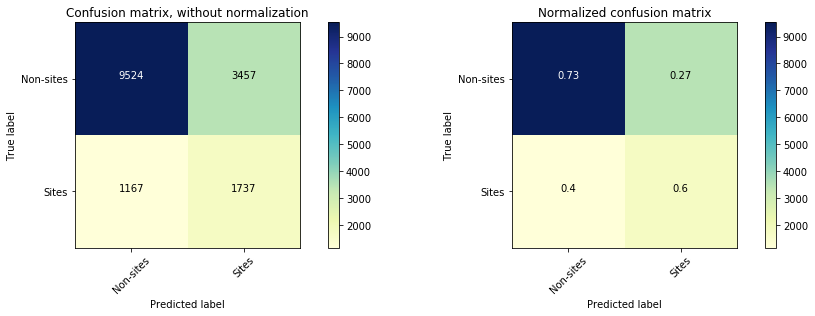

In [6]:
y_pred_max = [1 if i>=tresh1 else 0 for i in data['probability']]
cnf_data = m.plot_confusion_matrix(m.y_test,y_pred_max, True)
cnf_plots =  {'cnf':cnf_data[2], 'cnf_normed':cnf_data[3]}
m.show_plots(cnf_plots)

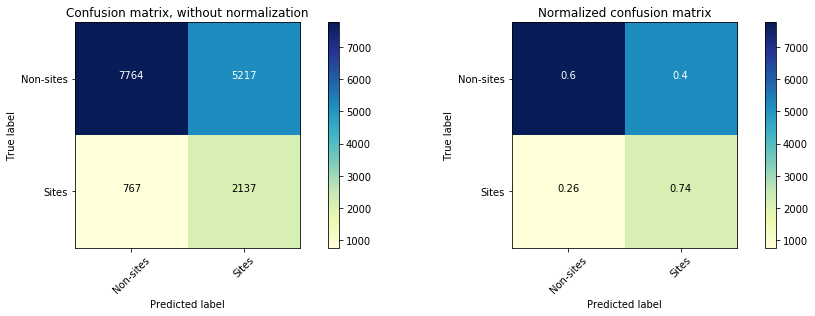

In [7]:
y_pred_max = [1 if i>=tresh2 else 0 for i in data['probability']]
cnf_data = m.plot_confusion_matrix(m.y_test,y_pred_max, True)
cnf_plots =  {'cnf':cnf_data[2], 'cnf_normed':cnf_data[3]}
m.show_plots(cnf_plots)

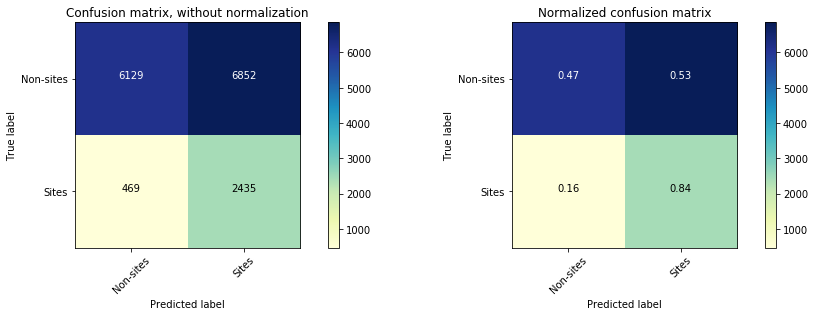

In [8]:
y_pred_max = [1 if i>=tresh3 else 0 for i in data['probability']]
cnf_data = m.plot_confusion_matrix(m.y_test,y_pred_max, True)
cnf_plots =  {'cnf':cnf_data[2], 'cnf_normed':cnf_data[3]}
m.show_plots(cnf_plots)